Import libraries

In [25]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Read the file

In [26]:
path = 'data/gps230120g002.hdf5'

file = h5py.File(path, 'r')

dataset = file['Data'].get('Table Layout') # type: ignore
data_array = np.array(dataset)


dataset1 = file['Data']['Array Layout']['2D Parameters']['tec'] # type: ignore
tec_array = np.array(dataset1)

file.close()

Form a pandas dataframe

In [27]:
df = pd.DataFrame(data_array)
df['minute'] = df['min']
df['second'] = df['sec']
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute', 'second']])
df = df.drop(['recno','kindat','kinst','ut1_unix','ut2_unix', 'year', 'month', 'day', 'hour', 'minute', 'second', 'min', 'sec'], axis=1)

Read the rest of the files

In [28]:
path = 'data/gps230121g002.hdf5'

file = h5py.File(path, 'r')

dataset = file['Data'].get('Table Layout') # type: ignore
data_array = np.array(dataset)

file.close()

df2 = pd.DataFrame(data_array)
df2['minute'] = df2['min']
df2['second'] = df2['sec']
df2['datetime'] = pd.to_datetime(df2[['year', 'month', 'day', 'hour', 'minute', 'second']])
df2 = df2.drop(['recno','kindat','kinst','ut1_unix','ut2_unix', 'year', 'month', 'day', 'hour', 'minute', 'second', 'min', 'sec'], axis=1)

In [29]:
path = 'data/gps230122g002.hdf5'

file = h5py.File(path, 'r')

dataset = file['Data'].get('Table Layout') # type: ignore
data_array = np.array(dataset)

file.close()

df3 = pd.DataFrame(data_array)
df3['minute'] = df3['min']
df3['second'] = df3['sec']
df3['datetime'] = pd.to_datetime(df3[['year', 'month', 'day', 'hour', 'minute', 'second']])
df3 = df3.drop(['recno','kindat','kinst','ut1_unix','ut2_unix', 'year', 'month', 'day', 'hour', 'minute', 'second', 'min', 'sec'], axis=1)

Join the dataframes

In [30]:
LAT = [55, 75]
LONG = 25

df = pd.concat([df, df2, df3], axis=0, ignore_index=True)
df = df.loc[(df['gdlat'] >= LAT[0]) & (df['gdlat'] <= LAT[1]) & (df['glon'] == LONG)]
df = df.sort_values(by=['gdlat', 'datetime'], ascending=True)
df

,gdlat,glon,tec,dtec,datetime
12543,55.0,25.0,4.092358,0.338171,2023-01-20 00:02:30
27942,55.0,25.0,3.848852,0.326961,2023-01-20 00:07:30
43104,55.0,25.0,4.226047,0.363869,2023-01-20 00:12:30
58609,55.0,25.0,3.573445,0.460186,2023-01-20 00:17:30
74585,55.0,25.0,2.650838,0.581981,2023-01-20 00:22:30
...,...,...,...,...,...
13211105,75.0,25.0,5.552358,1.321343,2023-01-22 23:37:30
13226371,75.0,25.0,6.480916,1.305505,2023-01-22 23:42:30
13241496,75.0,25.0,6.201181,1.320229,2023-01-22 23:47:30
13257025,75.0,25.0,2.595409,0.761132,2023-01-22 23:52:30


Plot the plot


C:\Users\virtanem\AppData\Local\Temp\ipykernel_22040\4263921737.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot1 = df.pivot('gdlat', 'datetime', 'tec')


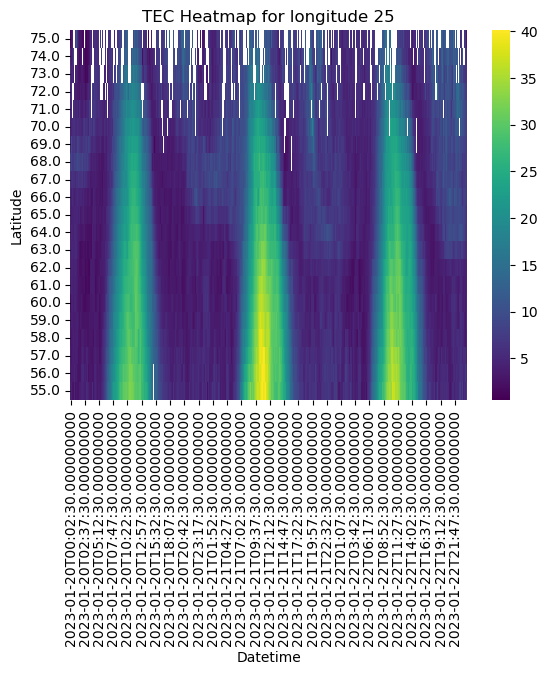

In [31]:
pivot1 = df.pivot('gdlat', 'datetime', 'tec')
sns.heatmap(pivot1, cmap='viridis')

plt.xlabel('Datetime')
plt.ylabel('Latitude')
plt.title(f'TEC Heatmap for longitude {LONG}')
plt.gca().invert_yaxis()

plt.show()

Rolling average

In [32]:
rolling_df = pd.DataFrame()

for lat in df['gdlat'].unique():
    df5 = df.loc[df['gdlat'] == lat]
    moving_avg = df5['tec'].rolling(window=36, min_periods=1, center=True).mean()
    rolling_df = pd.concat([rolling_df, moving_avg], axis=0)

df = pd.concat([df, rolling_df], axis=1)
df['rolling'] = df[0]
df = df.drop(columns=[0])

In [33]:
df['detrended_tec'] = df['tec'] - df['rolling']
df['detrended_tec'].describe()

count    17302.000000
mean        -0.001360
std          1.251869
min         -7.708367
25%         -0.780672
50%         -0.066081
75%          0.738174
max          8.101774
Name: detrended_tec, dtype: float64

Smoothed plot

C:\Users\virtanem\AppData\Local\Temp\ipykernel_22040\3977991069.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot = df.pivot('gdlat', 'datetime', 'detrended_tec')


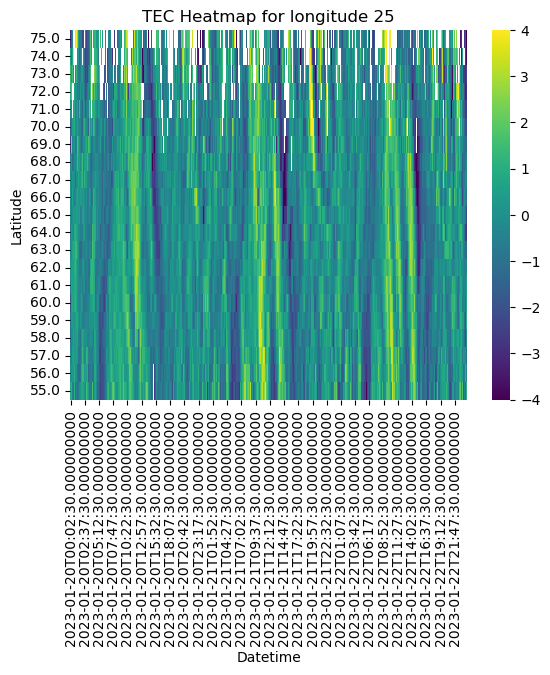

In [34]:
pivot = df.pivot(index='gdlat', columns='datetime', values='detrended_tec')
sns.heatmap(pivot, cmap='viridis', vmin=-4, vmax=4)

plt.gca().invert_yaxis()
plt.xlabel('Datetime')
plt.ylabel('Latitude')
plt.title(f'TEC Heatmap for longitude {LONG}')

plt.show()